### 1. Data Preprocessing


[Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) - place csv file in /src/data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('./data/creditcard.csv')

In [2]:
dataset.keys()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [3]:
dataset['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split


# stratified split
positive_cases = dataset[dataset['Class'] == 1]
negative_cases = dataset[dataset['Class'] == 0]

train_pos, test_pos = train_test_split(
    positive_cases, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(
    negative_cases, test_size=0.2, random_state=42)

train_pos_X, train_pos_y = train_pos.drop('Class', axis=1), train_pos['Class']
train_neg_X, train_neg_y = train_neg.drop('Class', axis=1), train_neg['Class']

test_pos_X, test_pos_y = test_pos.drop('Class', axis=1), test_pos['Class']
test_neg_X, test_neg_y = test_neg.drop('Class', axis=1), test_neg['Class']

train_X = pd.concat([train_pos_X, train_neg_X])
train_y = pd.concat([train_pos_y, train_neg_y])

test_X = pd.concat([test_pos_X, test_neg_X])
test_y = pd.concat([test_pos_y, test_neg_y])

### 2. Model Training

#### 2.1. Evaluation functions

In [5]:

import numpy as np


def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn


def recall(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
    return tp / (tp + fn)


def precision(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred)
    if tp + fp == 0:
        return 0
    return tp / (tp + fp)


def f1score(y_true, y_pred):
    rec = recall(y_true, y_pred)
    prec = precision(y_true, y_pred)
    return 2 * (rec * prec) / (rec + prec)

In [6]:
def calculate_roc_curve(y_true, y_scores):
    thresholds = np.sort(y_scores)
    tpr = []
    fpr = []

    for threshold in thresholds:
        # Classify based on the threshold
        predicted_class = (y_scores >= threshold).astype(int)

        # Calculate true positives, false positives, true negatives, false negatives
        tp = np.sum((predicted_class == 1) & (y_true == 1))
        fp = np.sum((predicted_class == 1) & (y_true == 0))
        tn = np.sum((predicted_class == 0) & (y_true == 0))
        fn = np.sum((predicted_class == 0) & (y_true == 1))

        # Calculate TPR and FPR
        tpr.append(tp / (tp + fn))  # Sensitivity, True Positive Rate
        fpr.append(fp / (fp + tn))  # 1 - Specificity, False Positive Rate

    return np.array(fpr), np.array(tpr), thresholds


def plot_roc(y_true, y_pred):
    points_x, points_y, thresholds = roc(y_true, y_pred)
    plt.plot(points_x, points_y)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

#### 2.2 Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

linear_regression_model = LogisticRegression(max_iter=1000)
linear_regression_model.fit(train_X, train_y)

lr_predictions = linear_regression_model.predict_proba(test_X)[:, 1]
lr_predictions_binary = (lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, lr_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.60      0.70        99

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2.3 Random Forest

In [8]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(
    n_estimators=100, random_state=42, max_depth=5)
random_forest_model.fit(train_X, train_y)

rf_predictions = random_forest_model.predict_proba(test_X)[:, 1]
rf_predictions_binary = (rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.90      0.71      0.79        99

    accuracy                           1.00     56962
   macro avg       0.95      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962



#### 2.4 KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_X, train_y)

knn_predictions = knn_model.predict_proba(test_X)[:, 1]
knn_predictions_binary = (knn_predictions > 0).astype(int)

print(classification_report(test_y, knn_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.13      0.25      0.17        99

    accuracy                           1.00     56962
   macro avg       0.56      0.62      0.58     56962
weighted avg       1.00      1.00      1.00     56962



#### 2.5 XGBoost

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index

xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5)
xgb_model.fit(train_X, train_y)

xgb_predictions = xgb_model.predict_proba(test_X)[:, 1]
xgb_predictions_binary = (xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, xgb_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### 3. Model Evaluation

#### Baseline Models

In [11]:
models = {"Logistic Regression": linear_regression_model,
          "Random Forest": random_forest_model,
          "KNN": knn_model,
          "XGBoost": xgb_model}

predictions = {"Logistic Regression": lr_predictions,
               "Random Forest": rf_predictions,
               "KNN": knn_predictions,
               "XGBoost": xgb_predictions}

model_threshold = {"Logistic Regression": 0.5,
                   "Random Forest": 0.5,
                   "KNN": 0.001,
                   "XGBoost": 0.5}

dir_name = {"Logistic Regression": "LR",
            "Random Forest": "RF",
            "KNN": "KNN",
            "XGBoost": "XGB"}

knn_predictions

array([0.2, 0. , 0.2, ..., 0. , 0. , 0. ])

#### Improved Models

In [22]:
models = {"Logistic Regression": im_linear_regression_model,
          "Random Forest": im_random_forest_model,
          "KNN": knn_model,
          "XGBoost": im_xgb_model}

predictions = {"Logistic Regression": im_lr_predictions,
               "Random Forest": im_rf_predictions,
               "KNN": knn_predictions,
               "XGBoost": im_xgb_predictions}

model_threshold = {"Logistic Regression": 0.5,
                   "Random Forest": 0.5,
                   "KNN": 0.001,
                   "XGBoost": 0.5}

dir_name = {"Logistic Regression": "LR",
            "Random Forest": "RF",
            "KNN": "KNN",
            "XGBoost": "XGB"}

#### 3.1 ROC Curve

Logistic Regression
Random Forest
KNN
XGBoost


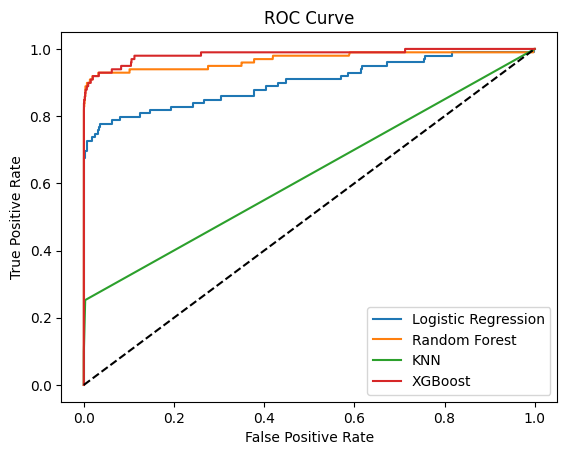

In [23]:
from sklearn.metrics import roc_curve

for name, model in models.items():
    print(name)
    fpr, tpr, thresholds = roc_curve(test_y, predictions[name])
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('./plots/roc_curve.png')
plt.show()

#### 3.2 Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from seaborn import heatmap

for name, model in models.items():
    print(name)
    thr = model_threshold[name]
    # thr = 0.5
    print(confusion_matrix(test_y, (predictions[name] >= thr).astype(int)))

    cm = confusion_matrix(test_y, (predictions[name] >= thr).astype(int))
    # disp = ConfusionMatrixDisplay(
    #     confusion_matrix=cm, display_labels=model.classes_)
    # disp.plot()

    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title(name)
    # plt.savefig(f'./plots/{dir_name[name]}/confusion_matrix.png')
    # plt.show()

Logistic Regression
[[56853    10]
 [   40    59]]
Random Forest
[[56855     8]
 [   29    70]]
KNN
[[56690   173]
 [   74    25]]
XGBoost
[[56857     6]
 [   22    77]]


#### 3.3 Precision-Recall Curve

Logistic Regression
Random Forest
KNN
XGBoost


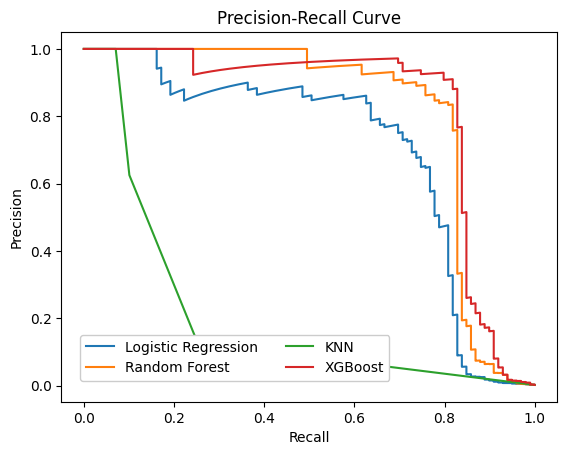

In [15]:
from sklearn.metrics import precision_recall_curve

for name, model in models.items():
    print(name)
    precision, recall, thresholds = precision_recall_curve(
        test_y, predictions[name])
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(
    0.35, +0.2), ncol=2, framealpha=1)
plt.savefig('./plots/precision_recall_curve.png')
plt.show()

#### 3.4 Precision, Recall, F1 Score, Accuracy Table

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize a dictionary to store the metrics
metrics = {"Model": [], "Precision": [],
           "Recall": [], "F1 Score": [], "Accuracy": []}

# Calculate metrics for each model
for name, model in models.items():
    thr = model_threshold[name]
    y_pred_binary = (predictions[name] >= thr).astype(int)
    precision = precision_score(test_y, y_pred_binary)
    recall = recall_score(test_y, y_pred_binary)
    f1 = f1_score(test_y, y_pred_binary)
    accuracy = accuracy_score(test_y, y_pred_binary)

    metrics["Model"].append(name)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)
    metrics["Accuracy"].append(accuracy)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                 Model  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression   0.855072  0.595960  0.702381  0.999122
1        Random Forest   0.897436  0.707071  0.790960  0.999350
2                  KNN   0.126263  0.252525  0.168350  0.995664
3              XGBoost   0.927711  0.777778  0.846154  0.999508


In [15]:
print(positive_cases.shape, negative_cases.shape)

(492, 31) (284315, 31)


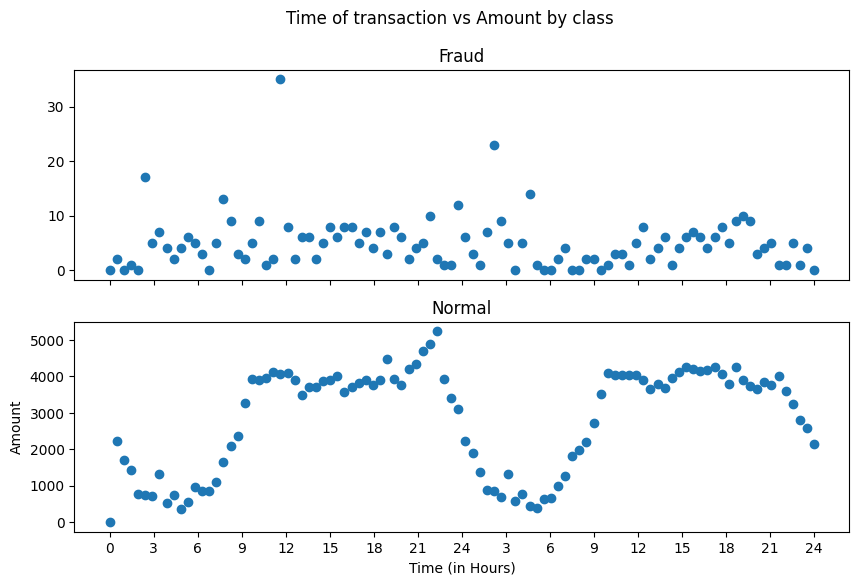

In [17]:
import numpy as np
pos_count = []
max_time = max(positive_cases["Time"].max(), negative_cases["Time"].max())
N = 100
times = np.linspace(0, max_time, N)
cnt = 0
for x in times:
    pos_count.append(
        positive_cases[(positive_cases["Time"] < x)].shape[0] - cnt)
    cnt = positive_cases[(positive_cases["Time"] < x)].shape[0]

neg_count = []
cnt = 0
for x in times:
    neg_count.append(
        negative_cases[(negative_cases["Time"] < x)].shape[0] - cnt)
    cnt = negative_cases[(negative_cases["Time"] < x)].shape[0]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(times, pos_count)
ax1.set_title('Fraud')
# ax1.set_xticks([0, 10800, 21600, 32400, 43200, 54000, 64800, 75600,
#                86400, 97200, 108000, 118800, 129600, 140400, 151200, 162000, 172800])
# ax1.set_xticklabels(['0', '3', '6', '9', '12', '15', '18',
#                     '21', '24', '3', '6', '9', '12', '15', '18', '21', '24'])

ax2.scatter(times, neg_count)
ax2.set_title('Normal')
plt.xlabel('Time (in Hours)')
ax2.set_xticks([0, 10800, 21600, 32400, 43200, 54000, 64800, 75600, 86400,
           97200, 108000, 118800, 129600, 140400, 151200, 162000, 172800], [0, 3, 6, 9, 12, 15, 18, 21, 24, 3, 6, 9, 12, 15, 18, 21, 24])
# plt.xticks(np.arange(0, max_time, 48))
plt.ylabel('Amount')
plt.savefig('./plots/transaction_amount_vs_time.png')
plt.show()

#### 3.5 Prediction time

In [18]:
import time

print(len(test_X))
for name, model in models.items():
    # print(name)
    start_time = time.time()
    model.predict_proba(test_X)
    end_time = time.time()

    print(f"Prediction time for {name}: {end_time - start_time} seconds")

56962
Prediction time for Logistic Regression: 0.005664825439453125 seconds
Prediction time for Random Forest: 0.09143447875976562 seconds
Prediction time for KNN: 13.48362684249878 seconds
Prediction time for XGBoost: 0.03359794616699219 seconds


### 4. Model Improvement

#### 4.1 Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

im_linear_regression_model = LogisticRegression(
    max_iter=40, n_jobs=-1, solver='liblinear')
im_linear_regression_model.fit(train_X, train_y)

im_lr_predictions = im_linear_regression_model.predict_proba(test_X)[:, 1]
im_lr_predictions_binary = (im_lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, im_lr_predictions_binary))

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.76      0.62      0.68        99

    accuracy                           1.00     56962
   macro avg       0.88      0.81      0.84     56962
weighted avg       1.00      1.00      1.00     56962



c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### 4.2 Random Forest

In [20]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

im_random_forest_model = RandomForestClassifier(
    n_estimators=100, random_state=42, max_features=10, max_depth=20, n_jobs=-1)
im_random_forest_model.fit(train_X, train_y)

im_rf_predictions = im_random_forest_model.predict_proba(test_X)[:, 1]
im_rf_predictions_binary = (im_rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, im_rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.82      0.86        99

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



#### 4.3 XGBoost

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd


# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index

im_xgb_model = XGBClassifier(n_estimators=200, random_state=42,
                             max_depth=20, n_jobs=-1, )
im_xgb_model.fit(train_X, train_y)

im_xgb_predictions = im_xgb_model.predict_proba(test_X)[:, 1]
im_xgb_predictions_binary = (im_xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, im_xgb_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### 5. Other method of sampling - SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
import pandas as pd


smote = SMOTE(random_state=42)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)

print("Before SMOTE:")
print(train_y.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(train_y_smote).value_counts())

Before SMOTE:
Class
0    227452
1       393
Name: count, dtype: int64

After SMOTE:
Class
1    227452
0    227452
Name: count, dtype: int64


#### 5.1 Model training Logistic Regression

In [25]:
smote_linear_regression_model = LogisticRegression(
    max_iter=10000, penalty='l1', solver='liblinear', n_jobs=-1)
smote_linear_regression_model.fit(train_X_smote, train_y_smote)

smote_lr_predictions = smote_linear_regression_model.predict_proba(test_X)[
    :, 1]
smote_lr_predictions_binary = (smote_lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, smote_lr_predictions_binary))

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.15      0.90      0.25        99

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962



#### 5.2 Model training Random Forest

In [26]:
smote_random_forest_model = RandomForestClassifier(
    n_estimators=100, random_state=42, max_features=10, max_depth=20, n_jobs=-1)
smote_random_forest_model.fit(train_X_smote, train_y_smote)

smote_rf_predictions = smote_random_forest_model.predict_proba(test_X)[:, 1]
smote_rf_predictions_binary = (smote_rf_predictions >= 0.5).astype(int)

print(classification_report(test_y, smote_rf_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.79      0.84      0.81        99

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



#### 5.3 Model training KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

smote_knn_model = KNeighborsClassifier(n_neighbors=5)
smote_knn_model.fit(train_X_smote, train_y_smote)

smote_knn_predictions = smote_knn_model.predict_proba(test_X)[:, 1]
smote_knn_predictions_binary = (smote_knn_predictions > 0).astype(int)

print(classification_report(test_y, smote_knn_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56863
           1       0.01      0.53      0.02        99

    accuracy                           0.88     56962
   macro avg       0.50      0.70      0.48     56962
weighted avg       1.00      0.88      0.94     56962



#### 5.4 Model training XGBoost

In [28]:
# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index

smote_xgb_model = XGBClassifier(n_estimators=100, random_state=42,
                                max_depth=20, max_features=10, n_jobs=-1)
smote_xgb_model.fit(train_X_smote, train_y_smote, eval_set=[
    (test_X, test_y)], verbose=False)

smote_xgb_predictions = smote_xgb_model.predict_proba(test_X)[:, 1]
smote_xgb_predictions_binary = (smote_xgb_predictions >= 0.5).astype(int)

print(classification_report(test_y, smote_xgb_predictions_binary))

c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.84      0.85        99

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [29]:
models = {"Logistic Regression": smote_linear_regression_model,
          "Random Forest": smote_random_forest_model,
          "KNN": smote_knn_model,
          "XGBoost": smote_xgb_model}

predictions = {"Logistic Regression": smote_lr_predictions,
               "Random Forest": smote_rf_predictions,
               "KNN": smote_knn_predictions,
               "XGBoost": smote_xgb_predictions}

model_threshold = {"Logistic Regression": 0.5,
                   "Random Forest": 0.5,
                   "KNN": 0.001,
                   "XGBoost": 0.5}

dir_name = {"Logistic Regression": "LR",
            "Random Forest": "RF",
            "KNN": "KNN",
            "XGBoost": "XGB"}

knn_predictions

array([0.2, 0. , 0.2, ..., 0. , 0. , 0. ])

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize a dictionary to store the metrics
metrics = {"Model": [], "Precision": [],
           "Recall": [], "F1 Score": [], "Accuracy": []}

# Calculate metrics for each model
for name, model in models.items():
    thr = model_threshold[name]
    y_pred_binary = (predictions[name] >= thr).astype(int)
    precision = precision_score(test_y, y_pred_binary)
    recall = recall_score(test_y, y_pred_binary)
    f1 = f1_score(test_y, y_pred_binary)
    accuracy = accuracy_score(test_y, y_pred_binary)

    metrics["Model"].append(name)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1 Score"].append(f1)
    metrics["Accuracy"].append(accuracy)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                 Model  Precision    Recall  F1 Score  Accuracy
0  Logistic Regression   0.147351  0.898990  0.253201  0.990783
1        Random Forest   0.790476  0.838384  0.813725  0.999333
2                  KNN   0.007808  0.525253  0.015387  0.883168
3              XGBoost   0.855670  0.838384  0.846939  0.999473


### 6. Other method of sampling - Bootstraping

In [31]:
from sklearn.utils import resample

n_bootstrap_samples = 5

bootstrap_samples = []
for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(
        train_X, train_y, replace=True, random_state=42)
    bootstrap_samples.append((X_sample, y_sample))

for i, (X_sample, y_sample) in enumerate(bootstrap_samples):
    print(f"Bootstrap sample {i+1}:")
    print(
        f"X_sample shape: {X_sample.shape}, y_sample shape: {y_sample.shape}")

Bootstrap sample 1:
X_sample shape: (227845, 30), y_sample shape: (227845,)
Bootstrap sample 2:
X_sample shape: (227845, 30), y_sample shape: (227845,)
Bootstrap sample 3:
X_sample shape: (227845, 30), y_sample shape: (227845,)
Bootstrap sample 4:
X_sample shape: (227845, 30), y_sample shape: (227845,)
Bootstrap sample 5:
X_sample shape: (227845, 30), y_sample shape: (227845,)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

logistic_model = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=42)
scaler = StandardScaler()


for i, (X_sample, y_sample) in enumerate(bootstrap_samples):
    print(f"\nTraining on Bootstrap Sample {i + 1}...")
    X_sample_scaled = scaler.fit_transform(X_sample)
    logistic_model.fit(X_sample_scaled, y_sample)
    y_pred = logistic_model.predict(X_sample_scaled)
    accuracy = accuracy_score(y_sample, y_pred)
    print(f"Accuracy on Bootstrap Sample {i + 1}: {accuracy:.4f}")

test_X_scaled = scaler.transform(test_X)
y_test_pred = logistic_model.predict(test_X_scaled)
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, y_test_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(test_y, y_test_pred))
print("\nClassification Report:")
print(classification_report(test_y, y_test_pred))


Training on Bootstrap Sample 1...
Accuracy on Bootstrap Sample 1: 0.9781

Training on Bootstrap Sample 2...
Accuracy on Bootstrap Sample 2: 0.9781

Training on Bootstrap Sample 3...
Accuracy on Bootstrap Sample 3: 0.9781

Training on Bootstrap Sample 4...
Accuracy on Bootstrap Sample 4: 0.9781

Training on Bootstrap Sample 5...
Accuracy on Bootstrap Sample 5: 0.9781

Test Set Evaluation:
Accuracy: 0.9772
Confusion Matrix:
[[55575  1288]
 [    8    91]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.07      0.92      0.12        99

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



### 7. Polynomial Features

In [33]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_X_poly = poly.fit_transform(train_X)
test_X_poly = poly.transform(test_X)

linear_regression_model = LogisticRegression(max_iter=1000)
linear_regression_model.fit(train_X_poly, train_y)

lr_predictions = linear_regression_model.predict_proba(test_X_poly)[:, 1]
lr_predictions_binary = (lr_predictions >= 0.5).astype(int)

print(classification_report(test_y, lr_predictions_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.63      0.71        99

    accuracy                           1.00     56962
   macro avg       0.91      0.81      0.86     56962
weighted avg       1.00      1.00      1.00     56962



c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 8. Attempt to improve models by Bootstrapping

#### 8.1 Polynomial Logistic Regression with Bootstrapping

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures

n_bootstrap_iterations = 5

all_predictions = []

for i in range(n_bootstrap_iterations):
    print(f"Bootstrap iteration {i + 1}/{n_bootstrap_iterations}")
    train_X_bootstrap, train_y_bootstrap = resample(train_X, train_y, random_state=i)

    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    train_X_poly = poly.fit_transform(train_X_bootstrap)
    test_X_poly = poly.transform(test_X)

    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(train_X_poly, train_y_bootstrap)

    lr_predictions = logistic_model.predict_proba(test_X_poly)[:, 1]
    all_predictions.append(lr_predictions)

mean_predictions = np.mean(all_predictions, axis=0)

lr_predictions_binary = (mean_predictions >= 0.5).astype(int)

print(classification_report(test_y, lr_predictions_binary))


Bootstrap iteration 1/5


c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bootstrap iteration 2/5


c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bootstrap iteration 3/5


c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bootstrap iteration 4/5


c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bootstrap iteration 5/5


c:\Users\Hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.66      0.74        99

    accuracy                           1.00     56962
   macro avg       0.93      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



#### 8.2 Random Forest with Bootstrapping

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample


n_bootstrap_iterations = 5

all_predictions = []


for i in range(n_bootstrap_iterations):
    print(f"Bootstrap iteration {i + 1}/{n_bootstrap_iterations}")
    train_X_bootstrap, train_y_bootstrap = resample(train_X, train_y, random_state=i)
    bs_random_forest_model = RandomForestClassifier(
        n_estimators=100, random_state=42, max_features=10, max_depth=20, n_jobs=-1
    )
    bs_random_forest_model.fit(train_X_bootstrap, train_y_bootstrap)
    bs_rf_predictions = bs_random_forest_model.predict_proba(test_X)[:, 1]
    all_predictions.append(bs_rf_predictions)

mean_predictions = np.mean(all_predictions, axis=0)

bs_rf_predictions_binary = (mean_predictions >= 0.5).astype(int)

print(classification_report(test_y, bs_rf_predictions_binary))

Bootstrap iteration 1/5
Bootstrap iteration 2/5
Bootstrap iteration 3/5
Bootstrap iteration 4/5
Bootstrap iteration 5/5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.82      0.86        99

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



#### 8.3 KNN with Bootstrapping

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample

n_bootstrap_iterations = 5

all_predictions = []

for i in range(n_bootstrap_iterations):
    print(f"Bootstrap iteration {i + 1}/{n_bootstrap_iterations}")
    train_X_bootstrap, train_y_bootstrap = resample(train_X, train_y, random_state=i)
    bs_knn_model = KNeighborsClassifier(n_neighbors=5)
    bs_knn_model.fit(train_X_bootstrap, train_y_bootstrap)
    bs_knn_predictions = bs_knn_model.predict_proba(test_X)[:, 1]
    all_predictions.append(bs_knn_predictions)

mean_predictions = np.mean(all_predictions, axis=0)

bs_knn_predictions_binary = (mean_predictions > 0).astype(int)

print(classification_report(test_y, bs_knn_predictions_binary))


Bootstrap iteration 1/5
Bootstrap iteration 2/5
Bootstrap iteration 3/5
Bootstrap iteration 4/5
Bootstrap iteration 5/5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.09      0.25      0.13        99

    accuracy                           0.99     56962
   macro avg       0.54      0.62      0.56     56962
weighted avg       1.00      0.99      1.00     56962



#### 8.4 XGBoost with Bootstrapping

In [41]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.utils import resample


n_bootstrap_iterations = 5

all_predictions = []


# Ensure compatibility with newer pandas versions
if not hasattr(pd, 'Int64Index'):
    pd.Int64Index = pd.Index


for i in range(n_bootstrap_iterations):
    print(f"Bootstrap iteration {i + 1}/{n_bootstrap_iterations}")
    train_X_bootstrap, train_y_bootstrap = resample(train_X, train_y, random_state=i)
    bs_xgb_model = XGBClassifier(n_estimators=200, random_state=42,
                             max_depth=20, n_jobs=-1, )
    bs_xgb_model.fit(train_X_bootstrap, train_y_bootstrap)
    bs_xgb_predictions = bs_xgb_model.predict_proba(test_X)[:, 1]
    all_predictions.append(bs_xgb_predictions)

mean_predictions = np.mean(all_predictions, axis=0)

bs_xgb_predictions_binary = (mean_predictions >= 0.5).astype(int)

print(classification_report(test_y, bs_xgb_predictions_binary))


Bootstrap iteration 1/5
Bootstrap iteration 2/5
Bootstrap iteration 3/5
Bootstrap iteration 4/5
Bootstrap iteration 5/5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.78      0.85        99

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962

